
* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def plot_prices(X, ext=''):
    plt.figure(figsize=(16,5))
    plt.title('Precio_Bolsa_Nacional_($kwh)' + ext)
    plt.xlabel('Días')
    plt.ylabel('kWh')
    plt.plot(X, color='black')
    plt.show();

# Preprocesamiento

### Leer los datos y almacenarlos por año

In [3]:
dfs = {}
for year in range(1995, 2016):
    dfs[str(year)] = pd.read_excel(f'./datos/precios/Precio_Bolsa_Nacional_($kwh)_{year}.xlsx')

for year in range(2016, 2019):
    dfs[str(year)] = pd.read_excel(f'./datos/precios/Precio_Bolsa_Nacional_($kwh)_{year}.xls')
    
dfs.keys()

dict_keys(['1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018'])

In [6]:
dfs['1995'].head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24
0,Precio Bolsa Nacional ($/kWh) 1995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Fecha,0.000,1.000,2.000,3.000,4.000,5.000,6.000,7.000,8.000,...,14.000,15.000,16.000,17.000,18.000,19.000,20.000,21.000,22.000,23.000
3,1995-07-20,NaN,1.073,1.073,1.073,1.073,1.073,1.073,1.073,1.074,...,1.073,1.073,1.073,1.073,1.074,1.897,1.897,1.897,1.073,1.073
4,1995-07-21,1.073,1.000,1.000,1.000,1.000,1.000,5.000,6.000,6.000,...,5.000,1.000,1.000,5.000,12.000,16.670,11.929,5.000,1.000,1.000


**Renombrar columnas, eliminar las primeras filas inválidas, eliminar filas duplicadas y calcular el promedio por día**

In [7]:
def preprocessing_columnsname_duplicates(df_y, year):
    df = df_y.copy()
    
    df.columns = [f'col{i}' for i in range(len(df.columns))]

    # renombrar las columnas del dataframe
    columns = np.squeeze(df.loc[df[df.columns[0]] == 'Fecha'].values)
    lindex = int(df.loc[df[df.columns[0]] == 'Fecha'].index.values) + 1
    df.columns = columns
    # eliminar las filas primeras filas inválidas
    df = df.drop(list(range(0, lindex)))
    
    # eliminar filas duplicadas
    shp_old = df.shape[0]
    df = df.drop_duplicates()
    print(f'Dataframe {year}, Final shape: {df.shape}, duplicates: {shp_old - df.shape[0]}')

    return df


def generate_average_kWh(df_y):
    # Calcular promedio de los kWh
    df = pd.DataFrame()
    df['Fecha'] = df_y['Fecha']
    df['mean'] = df_y.mean(axis=1)
    return df

In [8]:
for year in range(1995, 2019):
    year = str(year)
    dfs[year] = preprocessing_columnsname_duplicates(dfs[year], year)
    dfs[year] = generate_average_kWh(dfs[year])

Dataframe 1995, Final shape: (165, 25), duplicates: 0
Dataframe 1996, Final shape: (371, 25), duplicates: 7
Dataframe 1997, Final shape: (365, 25), duplicates: 0
Dataframe 1998, Final shape: (368, 25), duplicates: 19
Dataframe 1999, Final shape: (367, 25), duplicates: 7
Dataframe 2000, Final shape: (366, 26), duplicates: 0
Dataframe 2001, Final shape: (365, 25), duplicates: 0
Dataframe 2002, Final shape: (365, 25), duplicates: 0
Dataframe 2003, Final shape: (365, 25), duplicates: 0
Dataframe 2004, Final shape: (366, 25), duplicates: 0
Dataframe 2005, Final shape: (365, 26), duplicates: 0
Dataframe 2006, Final shape: (365, 25), duplicates: 0
Dataframe 2007, Final shape: (368, 25), duplicates: 11
Dataframe 2008, Final shape: (366, 25), duplicates: 0
Dataframe 2009, Final shape: (367, 25), duplicates: 15
Dataframe 2010, Final shape: (365, 26), duplicates: 0
Dataframe 2011, Final shape: (367, 27), duplicates: 2
Dataframe 2012, Final shape: (367, 27), duplicates: 0
Dataframe 2013, Final sha

**Concatenar los años y eliminar filas na**

In [9]:
years = sorted(list(dfs))
df_concatenated = pd.concat([dfs[y] for y in years], axis=0)

print(df_concatenated.shape)
df_concatenated = df_concatenated.dropna()
print(df_concatenated.shape)
df_concatenated.head()

(8348, 2)
(8341, 2)


,Fecha,mean
3,1995-07-20,1.409435
4,1995-07-21,4.924333
5,1995-07-22,1.269500
6,1995-07-23,0.953083
7,1995-07-24,4.305917


**Gráfica kWh promedio desde el año 1995 al 2018**

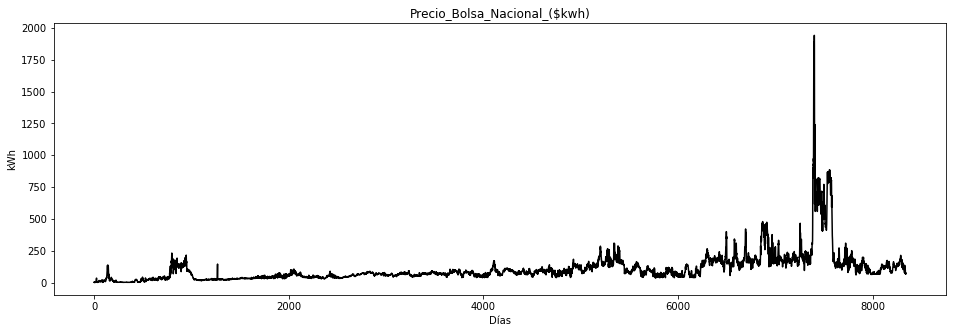

In [10]:
plot_prices(df_concatenated['mean'].values)

## Transformación Box-Cox

In [11]:
from sklearn.preprocessing import PowerTransformer

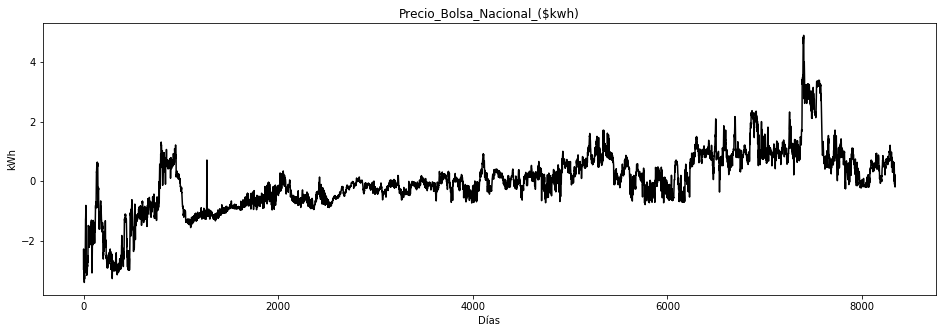

In [12]:
boxcox = PowerTransformer(method='box-cox')
x_transformed = boxcox.fit_transform(df_concatenated['mean'].values.reshape(-1, 1))
plot_prices(x_transformed)

# ADALINE

In [13]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

In [14]:
class ADALINE(object):
    def __init__(self, L):
        self.w = tfe.Variable([0.0] * (L+1))

    def __call__(self, x):
        if type(x) is np.ndarray:
            x = tf.constant(np.concatenate(([1.0], x)), dtype=np.float32)
        else:
            x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        y_pred = tf.reduce_sum(tf.multiply(self.w, x))
        return y_pred

In [15]:
seed = 12345

# función a ser optimizada
def loss(model, inputs, targets):
    error = model(inputs) - targets
    return tf.square(error)


# registra todas las operaciones para aplicar posteriormente el gradiente
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets)
    return tape.gradient(loss_value, [model.w])


# retorna la función de optimización a utilizar
def get_optimizer(mu, method='gradient', momentum=0.5):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=mu)
    if method == 'momentum':
        optimizer = tf.train.MomentumOptimizer(learning_rate=mu, momentum=momentum)
    return optimizer


# pronóstico para los precios de los próximos n días
def predict_n_days(model, data, delays, ndays):
    pred = list(data[len(data) - delays:])
    for i in range(0, ndays):
        pred.append(model(pred[i:]).numpy())
    return pred, delays


def plot_y_vs_pred(y, pred):
    plt.figure(figsize=(14,3))
    plt.plot(y, color='black')
    plt.plot(pred, color='red')
    plt.show();

## 1 - ADALINE sin parámetros óptimos

### Precalentamiento de los pesos del ADALINE

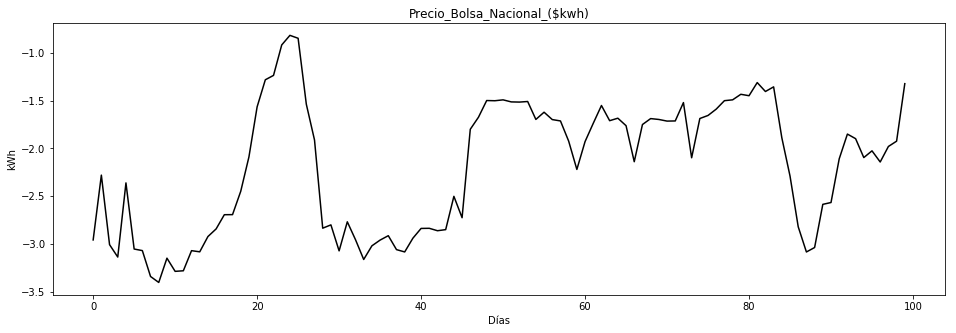

In [16]:
precalentamiento = x_transformed[0:100]
d_transformed = x_transformed[100:]
precalentamiento = precalentamiento.reshape(-1)
plot_prices(precalentamiento)

In [17]:
L = 10
epochs = 100

model = ADALINE(L)
optimizer = get_optimizer(mu=0.005)

np.random.seed(seed)
tf.set_random_seed(seed)
for _ in range(epochs):
    for t in range(L, len(precalentamiento)):
        x = precalentamiento[t-L:t]
        grads = grad(model, x, precalentamiento[t])
        optimizer.apply_gradients(zip(grads, [model.w]), global_step=tf.train.get_or_create_global_step())

print('Pesos W =', model.w.numpy())

Pesos W = [-0.0644815   0.14197843  0.08778314  0.08027364  0.05608528  0.0075503
  0.01588246  0.02150935  0.04868552  0.09582163  0.13544475]


### Entrenamiento del ADALINE

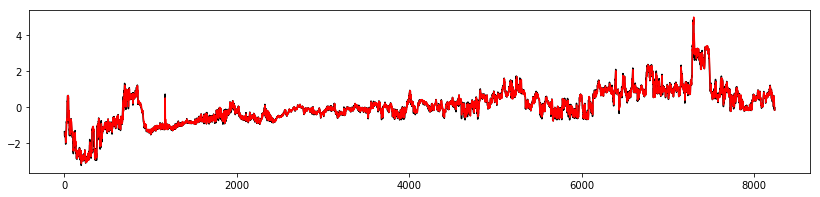

In [74]:
y_objetivo = d_transformed.reshape(-1)
y_pred = np.empty(len(y_objetivo))
y_pred[:] = np.nan

SSE = []

np.random.seed(seed)
tf.set_random_seed(seed)
for _ in range(epochs):
    _sse = 0
    for t in range(L, len(y_objetivo)):
        
        x = y_objetivo[t-L:t]
        y_pred[t] = model(x)
        _sse += loss(model, x, y_objetivo[t])
        
        grads = grad(model, x, y_objetivo[t])
        optimizer.apply_gradients(zip(grads, [model.w]), global_step=tf.train.get_or_create_global_step())
        
    SSE.append(_sse)

plot_y_vs_pred(y_objetivo, y_pred)

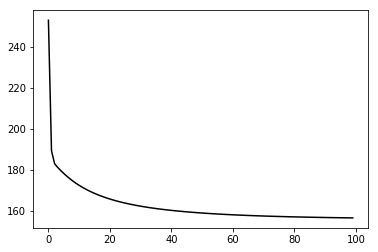

In [75]:
plt.plot(SSE, color='black');

### Generar el pronóstico para los precios de los próximos siete días.

**Aplicar transformación inversa box-cox a los resultados del pronóstico**

In [106]:
result_transformed = predict_n_days(model=model, data=y_objetivo, delays=L, ndays=7)
result_inverse = boxcox.inverse_transform(np.array(result_transformed[0]).reshape(-1, 1))
result_inverse[L:]

array([[77.90626109],
       [76.57170166],
       [74.46708696],
       [72.33497053],
       [73.41768757],
       [69.97045659],
       [69.6627253 ]])

Pronóstico para los precios de los próximos siete días


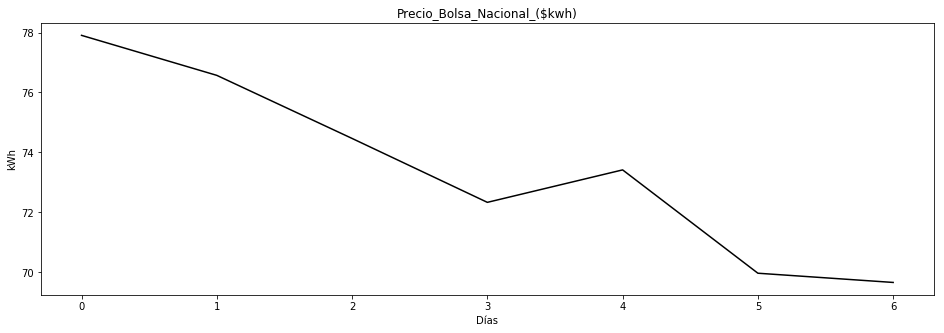

In [112]:
print('Pronóstico para los precios de los próximos siete días')
plot_prices(result_inverse[L:])

## 2 - ADALINE con parámetros óptimos

## Determinar los hiperparametros del modelo

In [18]:
def sse_score_model(data):
    L = data['L']
    mu = data['mu']
    epochs = data['epochs']
    precalentamiento = data['precalentamiento']
    d_transformed = data['d_transformed']
    seed = data['seed']
    
    model = ADALINE(L)
    optimizer = get_optimizer(mu=mu)

    # precalentamiento
    np.random.seed(seed)
    tf.set_random_seed(seed)
    for _ in range(epochs):
        for t in range(L, len(precalentamiento)):
            x = precalentamiento[t-L:t]
            grads = grad(model, x, precalentamiento[t])
            optimizer.apply_gradients(zip(grads, [model.w]), global_step=tf.train.get_or_create_global_step())
            
    # entrenamiento
    SSE = []
    y_objetivo = d_transformed.reshape(-1)       
    np.random.seed(seed)
    tf.set_random_seed(seed)
    for _ in range(epochs):
        _sse = 0
        for t in range(L, len(y_objetivo)):
            x = y_objetivo[t-L:t]
            _sse += loss(model, x, y_objetivo[t])

            grads = grad(model, x, y_objetivo[t])
            optimizer.apply_gradients(zip(grads, [model.w]), global_step=tf.train.get_or_create_global_step())

        SSE.append(_sse)
        
    return SSE[-1].numpy()

In [19]:
def param_search(epochs, learning_rate, L, precalentamiento, d_transformed, seed):
    score_mse = []    
    
    for epoch in epochs:
        for mu in learning_rate:
            for l in L:
                result = sse_score_model({
                    'L': l,
                    'mu': mu,
                    'epochs': epoch,
                    'precalentamiento': precalentamiento,
                    'd_transformed': d_transformed,
                    'seed': seed
                })
                params = {'epochs': epoch, 'mu': mu, 'L': l}
                score_mse.append((result, params))            
                print(f"{result:<10.2f} para {params}")
    
    return score_mse

In [30]:
import time

In [44]:
start = time.time()
result = np.array(param_search(
    epochs=[1, 15, 30, 45], 
    learning_rate=[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007], 
    L=[5, 10, 15, 20, 40, 80], 
    precalentamiento=precalentamiento, 
    d_transformed=d_transformed, 
    seed=seed
))

i_min = np.argmin(result[:,0])
print(f'\nParámetros óptimos: {result[i_min, 1]}')
print(f'Tiempo total: {(time.time() - start):.2f} s')

219.85     para {'epochs': 1, 'mu': 0.001, 'L': 5}
232.03     para {'epochs': 1, 'mu': 0.001, 'L': 10}
242.10     para {'epochs': 1, 'mu': 0.001, 'L': 15}
254.86     para {'epochs': 1, 'mu': 0.001, 'L': 20}
252.52     para {'epochs': 1, 'mu': 0.001, 'L': 40}
253.31     para {'epochs': 1, 'mu': 0.001, 'L': 80}
200.94     para {'epochs': 1, 'mu': 0.002, 'L': 5}
205.90     para {'epochs': 1, 'mu': 0.002, 'L': 10}
214.72     para {'epochs': 1, 'mu': 0.002, 'L': 15}
223.46     para {'epochs': 1, 'mu': 0.002, 'L': 20}
228.84     para {'epochs': 1, 'mu': 0.002, 'L': 40}
nan        para {'epochs': 1, 'mu': 0.002, 'L': 80}
191.87     para {'epochs': 1, 'mu': 0.003, 'L': 5}
195.78     para {'epochs': 1, 'mu': 0.003, 'L': 10}
204.74     para {'epochs': 1, 'mu': 0.003, 'L': 15}
213.12     para {'epochs': 1, 'mu': 0.003, 'L': 20}
9184794749043941948394101240483545088.00 para {'epochs': 1, 'mu': 0.003, 'L': 40}
nan        para {'epochs': 1, 'mu': 0.003, 'L': 80}
186.89     para {'epochs': 1, 'mu': 0

nan        para {'epochs': 45, 'mu': 0.005, 'L': 40}
nan        para {'epochs': 45, 'mu': 0.005, 'L': 80}
166.96     para {'epochs': 45, 'mu': 0.006, 'L': 5}
442.38     para {'epochs': 45, 'mu': 0.006, 'L': 10}
nan        para {'epochs': 45, 'mu': 0.006, 'L': 15}
nan        para {'epochs': 45, 'mu': 0.006, 'L': 20}
nan        para {'epochs': 45, 'mu': 0.006, 'L': 40}
nan        para {'epochs': 45, 'mu': 0.006, 'L': 80}
167.91     para {'epochs': 45, 'mu': 0.007, 'L': 5}
964793.44  para {'epochs': 45, 'mu': 0.007, 'L': 10}
nan        para {'epochs': 45, 'mu': 0.007, 'L': 15}
nan        para {'epochs': 45, 'mu': 0.007, 'L': 20}
nan        para {'epochs': 45, 'mu': 0.007, 'L': 40}
nan        para {'epochs': 45, 'mu': 0.007, 'L': 80}

Parámetros óptimos: {'epochs': 45, 'mu': 0.001, 'L': 40}
Tiempo total: 12832.27 s


In [45]:
result[i_min]

array([155.34103, {'epochs': 45, 'mu': 0.001, 'L': 40}], dtype=object)

### Entrenamiento y pronóstico con parámetros óptimos

* L: 40
* mu: 0.001
* epochs: 45

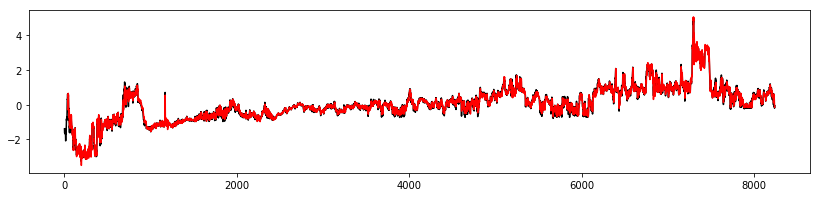

In [48]:
L = 40
epochs = 45
mu = 0.001

model = ADALINE(L)
optimizer = get_optimizer(mu=mu)

np.random.seed(seed)
tf.set_random_seed(seed)
for _ in range(epochs):
    for t in range(L, len(precalentamiento)):
        x = precalentamiento[t-L:t]
        grads = grad(model, x, precalentamiento[t])
        optimizer.apply_gradients(zip(grads, [model.w]), global_step=tf.train.get_or_create_global_step())
        
        
y_objetivo = d_transformed.reshape(-1)
y_pred = np.empty(len(y_objetivo))
y_pred[:] = np.nan

SSE = []

np.random.seed(seed)
tf.set_random_seed(seed)
for _ in range(epochs):
    _sse = 0
    for t in range(L, len(y_objetivo)):
        
        x = y_objetivo[t-L:t]
        y_pred[t] = model(x)
        _sse += loss(model, x, y_objetivo[t])
        
        grads = grad(model, x, y_objetivo[t])
        optimizer.apply_gradients(zip(grads, [model.w]), global_step=tf.train.get_or_create_global_step())
        
    SSE.append(_sse)

plot_y_vs_pred(y_objetivo, y_pred)

In [49]:
result_transformed = predict_n_days(model=model, data=y_objetivo, delays=L, ndays=7)
result_inverse = boxcox.inverse_transform(np.array(result_transformed[0]).reshape(-1, 1))
result_inverse[L:]

array([[71.75316617],
       [85.1184536 ],
       [86.45611948],
       [89.91914732],
       [88.10400721],
       [84.38913647],
       [82.12346995]])

Pronóstico para los precios de los próximos siete días


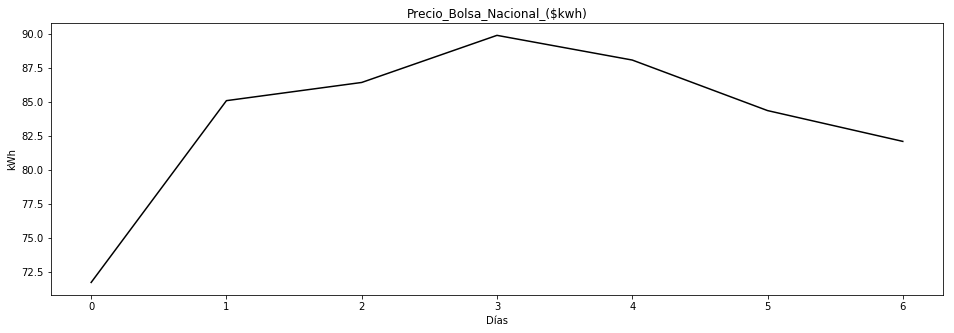

In [50]:
print('Pronóstico para los precios de los próximos siete días')
plot_prices(result_inverse[L:])

**40 días + 7 días pronósticados**

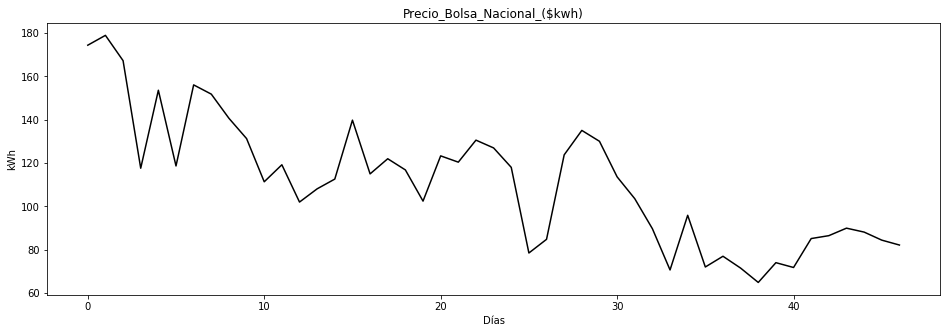

In [52]:
plot_prices(result_inverse)